# Learning Pandas using Enigma.io's API and datasets.


##This notebook uses Pandas to explore a dataset exported from Enigma.io.<br>It serves 2 goals:

### 1. Learn Pandas: apply the concepts learned in these Pandas tutorials, to a random dataset:
  - Wes McKinney's "Data analysis in Python with pandas."  (https://youtu.be/w26x-z-BdWQ)
  - Greg Reda's "Translating SQL to pandas. And back." (https://youtu.be/1uVWjdAbgBg)
  - Sarah Guido "Hands-on Data Analysis with Python." (https://youtu.be/L4Hbv4ugUWk)

### 2. Become familiar with some of Enigma.io's content, services, tools:

- Its website, currently available datasets, typical schema & metadata of the datasets, Enigma API, etc.


##Note about the datasets:
Ideally I'd use different classes of datasets: that overlap through some columns, but that also augment each other.

Putting datasets from separate origins on a common "Enigma" plane, and providing "normalized" access and tools (exploratory, analytical, predictive) is what makes Enigma particularly interesting.

But at this point my main objective is to learn Pandas, and therefore baby Pandas steps. Start with datasets that provide information about NYC property assessments (2010, 2012, 2014).

---

##Some of the work that follows:

- Downloaded the datasets from Enigma, using an initial version of a Python client which provides support for the "export" API.
- Initial exploration of the dataset: memory, number of rows, schema, some content cleanup, etc.
- Columns: renaming to make them easier to read, dropping some, adding "synthetic" ones, etc.
- Performed a series of "nosy" queries. Examples:
  * highest/lowest valued properties per zip code; in my block, etc.
  * who owns the most real estate (hint: Deutschland not just powerful at soccer).
  * zips with most properties valued around $1M? $5M (hint: Park Slopers doing well, but can't keep up)

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np



## Download the datasets making use of enigma.io API.

Go to last cell in this notebook, which shows an initial version of a Python client to enigma.io.<br>To download the datasets, the module containing the client would be invoked like this...

     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2010
     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2012
     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2014

## These will be our datasets: NYC property assessments from 2010, 2012 and 2014.

In [22]:
import os
from collections import defaultdict

#### leave out 2012 for now (too much memory for my humble laptop)
# datasets_years = (2010, 2012, 2014)
# dataset_csv_files = ["nyc.prop_assess_2010.csv",
#                      "nyc.prop_assess_2012.csv",
#                      "nyc.prop_assess_2014.csv",]
datasets_years = (2010, 2014)
data_dirname = "./data/nyc_property_assessments"
dataset_csv_files = ["nyc.prop_assess_2010.csv",
                     "nyc.prop_assess_2014.csv"]

# Use a dict to store info for each dataset (the dict's keys are the years)
# (dataset csv filename, dataframe handle, etc.)
datasets_info = defaultdict(dict)

# for now the only info for each dataset is its csv fname
# more info will be added.
for dataset_keyname, fname in zip(datasets_years, dataset_csv_files):
    datasets_info[dataset_keyname]["csv_file"] = os.path.join(data_dirname, fname)

## Get an initial idea of what we have. File sizes & number of rows.

In [23]:
import os

for dset in datasets_info.values():
    fname = dset["csv_file"]
    wc_info = !wc -l $fname
    print("Info for file {}:".format(fname))
    print("   Number of rows: {}".format(wc_info[0].split()[0]))
    print("   File size:      {:,}".format(os.stat(fname).st_size))
    print()

Info for file ./data/nyc_property_assessments/nyc.prop_assess_2010.csv:
   Number of rows: 1060513
   File size:      185,122,823

Info for file ./data/nyc_property_assessments/nyc.prop_assess_2014.csv:
   Number of rows: 1088351
   File size:      164,461,696



## Read the datasets into Pandas DataFrames.

In [24]:
%%time
# Some cols generating warnings during the read (mixed dtypes). Be specific.
for dset_key in datasets_info.keys():
    dset = datasets_info[dset_key]
    dset["df"] = pd.read_csv(dset["csv_file"], dtype={"bble": object, "easement": object})

CPU times: user 20.1 s, sys: 14.4 s, total: 34.6 s
Wall time: 54.5 s


## Some schema exploration...

***

### <<< <a id="cols_start">START OF COLUMNS PROCESSING</a> >>>

### The cells that follow operate on the dataframes' columns<br>(renaming, dropping some, adding new ones, "cleaning" cols of dtype "string", etc.). 

To skip to the last of these cells, search for ["END OF COLUMNS PROCESSING"](#cols_end).

*** Note: *** these adjustments to the columns is the result of the intial work done in a previous notebook; it contains comments about why I perform these add/del/modifications - "enigma_nyc_properties_2010.ipynb").

In [25]:
# we'll be using each dataset's dataframe handle (df) frequently
# Provide a small util func/generator to return back each dataset's (year, df)
from collections import namedtuple
DFInfo = namedtuple('DFInfo', ['year', 'df'])
def _dfs():
    for dset_year in datasets_info.keys():
        dfi = DFInfo(dset_year, datasets_info[dset_year]["df"])
        yield dfi

### What are the dataframe's columns?

In [26]:
# Column names not that visually clear; make them easier to read...
def prettify_colnames(columns, cols_per_row=7):
    cols = sorted(columns)
    colsize = 2 + max(len(colname) for colname in cols)
    outstr = ""
    for ix, colname in enumerate(cols):
        outstr += "{newline}{cn:{sz}}".format(
            newline="" if (ix+1) % cols_per_row else "\n", cn=colname, sz=colsize)
    return outstr

for dfi in _dfs():
    print("\n\nDataset {} columns...\n{}".format(dfi.year, prettify_colnames(dfi.df.columns)))



Dataset 2010 columns...
avland    avland2   avtot     avtot2    bble      blddepth  
bldfront  bldgcl    block     borough   easement  excd1     excd2     
exland    exland2   exmptcl   ext       extot     extot2    fullval   
lot       ltdepth   ltfront   owner     period    serialid  staddr    
stories   taxclass  valtype   year      zip       


Dataset 2014 columns...
avland    avland2   avtot     avtot2    b         bble      
blddepth  bldfront  bldgcl    block     easement  excd1     excd2     
exland    exland2   exmptcl   ext       extot     extot2    fullval   
lot       ltdepth   ltfront   owner     period    serialid  staddr    
stories   taxclass  valtype   year      zip       


## What do these column headers mean!? Kind of cryptic names...

### Navigate enigma.io website. <br>You can click on "Description" for any table/dataset.<br>A modal window pops up.<br> You can choose to "export" the column descriptions as a file.

Downloaded it, unzipped it. It contains 2 files...

     table-info.csv
     column-info.csv     

### Read the column-info.csv file.

In [27]:
## 2012 out for now...
#columns_csv_files = ["2010-column-info.csv", "2010-column-info.csv", ]
columns_csv_files = ["2010-column-info.csv", "2014-column-info.csv"]

for dataset_keyname, fname in zip(datasets_years, columns_csv_files):
    fname = os.path.join(data_dirname, fname)
    datasets_info[dataset_keyname]["cols_csv_file"] = fname
    datasets_info[dataset_keyname]["cols_df"] = pd.read_csv(fname)

### Get some info about the columns.<br>Make sure schemas/cols across years contain the same columns we'll use later.

In [28]:
for ds_key in datasets_info:
    print("\n\n===========> Cols for year: {}".format(ds_key))
    datasets_info[ds_key]["cols_df"].info()



===========> Cols for year: 2010
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
Column Name           32 non-null object
Column Description    32 non-null object
Column API ID         32 non-null object
Column Type           32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


===========> Cols for year: 2014
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
Column Name           32 non-null object
Column Description    32 non-null object
Column API ID         32 non-null object
Column Type           32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


### All ok if the various datasets contain the same columns except for the renaming of ("borough" <=> "b").

In [29]:
# Stop if columns are not what we expect.
reference_set = {col for col in datasets_info[2014]["cols_df"]["Column API ID"]}

for dset_key in datasets_info:
    diff = reference_set ^ {col for col in datasets_info[dset_key]["cols_df"]["Column API ID"]}
    assert len(diff - {'b', 'borough'}) == 0

### Select what seems like a useful subset of the 32 columns.<br> We'll use this col subset for our data exploration.

In [30]:
# these columns seem interesting 
# (owner, street name & number, value, lot front/depth in ft., num of stories, ...)
colnames = ["owner",
            "fullval",
            "zip",
            "block",
            "staddr",
            "ltfront",
            "ltdepth",
            "stories",
            "taxclass",
            "easement"]

# index the descr table by the cryptic API name (use 2014 colnames table as a ref.).
cidx = datasets_info[2014]["cols_df"].set_index("Column API ID")

# map the cryptic dataset colnames to more user-friendly names
# (preserve the col order listed above)
from collections import OrderedDict
cols_subset = OrderedDict()
for cn in colnames:
    cols_subset[cn] = cidx.ix[cn]["Column Name"].strip()

##Rename columns of interest.<br>Drop all others.<br>Reindex the (reduced + renamed) columns<br>(display in order shown in colnames list above).

In [31]:
def drop_some_cols(df, cols_subset):
    all_cols = set(df.columns)
    df_cols_reduced = df.drop(all_cols - set(cols_subset), axis=1)
    return df_cols_reduced

def rename_some_cols(df, cols_subset):
    df_renamed = df.rename(columns = cols_subset)
    return df_renamed

def reindex_cols(df, ordered_cols):
    df_reindexed = df.reindex_axis(ordered_cols, axis=1)
    return df_reindexed

for dfinfo in _dfs():
    df_subset = drop_some_cols(dfinfo.df, cols_subset.keys())
    df_subset = rename_some_cols(df_subset, cols_subset)
    # remember that cols_subset is an OrderedDict (already in the order we want)
    df_subset = reindex_cols(df_subset, cols_subset.values())
    
    datasets_info[dfinfo.year]["dfsub"] = df_subset

# don't accumulate unneeded large objects
del df_subset

In [32]:
# repeat utility func to make it easeier to get at subset df handle.
DFInfo = namedtuple('DFInfo', ['year', 'dfsub'])
def _subdfs():
    for dset_year in datasets_info.keys():
        dfi = DFInfo(dset_year, datasets_info[dset_year]["dfsub"])
        yield dfi

## Facilitate operating on some "string" columns (owner, address).

In [33]:
normalize_str_colnames = ["Owner", "Street Address"]

def strip_and_upper(s):
     return s.strip().upper()

for dfinfo in _subdfs():
    for colname in normalize_str_colnames:
        dfinfo.dfsub[colname].fillna("", inplace=True)
        dfinfo.dfsub[colname] = dfinfo.dfsub[colname].map(strip_and_upper)

## Let's create a column that displays the "Full Value" column in a human-friendly format.


In [34]:
for dfinfo in _subdfs():
    dfinfo.dfsub["FullValueUX"] = dfinfo.dfsub["Full Value"].map("${:,.0f}".format)

In [35]:
# Let's put the new (long-named) columns in a list so that
# we don't have to type them every time...
cols_to_show = list(cidx.ix[cols_subset.keys()]["Column Name"])

# and insert the formatted FullValueUX as a leading col 
# (put unformatted as last one - don't drop it - we need it for float ops)
cols_to_show[1:2] = ["FullValueUX"]
cols_to_show.append("Full Value")

## Add synthetic total square footage column.

In [36]:
for dfinfo in _subdfs():
    dfinfo.dfsub["SquareFt"] = np.round(dfinfo.dfsub["Lot Frontage"] * dfinfo.dfsub["Lot Depth"])
cols_to_show.append("SquareFt")

##Create an arbitrary definition of what a "residential house" is.

###Used to make queries that apply more to residential than commercial properties.

<ol>
   <li> Cap the square footage to <= 3000 </li>
   <li> Cap the property's num of stories to <= 3 </li>
   <li> Tax Class == 1</li>
</ol>


##Add synthetic "residential" column (True, False).

In [37]:
for dfinfo in _subdfs():
    dfinfo.dfsub["Residential"] = ((dfinfo.dfsub.SquareFt <= 3000) & 
                                   (dfinfo.dfsub.Stories <= 3) & 
                                   (dfinfo.dfsub["Tax Class"] == "1"))
    
cols_to_show.append("Residential")

***

### <<< <a id="cols_end">END OF COLUMNS PROCESSING</a> >>>

*** or, jump back to the [Start of Columns Processing](#cols_start) ***

***

##  Schema cleanup done for now.<br>Start some data exploration and queries.

### DataFrames info:
* most cells populated
* easements mostly null, which makes sense
* around 100MBytes per DF

In [38]:
for dfinfo in _subdfs():
    print("\n\n========> DataFrame info for year {}".format(dfinfo.year))
    dfinfo.dfsub.info()



========> DataFrame info for year 2010
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060512 entries, 0 to 1060511
Data columns (total 13 columns):
Owner             1060512 non-null object
Full Value        1060512 non-null float64
Zip               1030018 non-null float64
Block             1060512 non-null int64
Street Address    1060512 non-null object
Lot Frontage      1060512 non-null int64
Lot Depth         1060512 non-null int64
Stories           1003082 non-null float64
Tax Class         1060512 non-null object
Easement          4615 non-null object
FullValueUX       1060512 non-null object
SquareFt          1060512 non-null int64
Residential       1060512 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 106.2+ MB


========> DataFrame info for year 2014
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1088350 entries, 0 to 1088349
Data columns (total 13 columns):
Owner             1088350 non-null object
Full Value        1088350 non-null in

In [39]:
# ok, let's create shortcuts for the dataframes we'll use (subset of cleaned-up cols)
df10 = datasets_info[2010]["dfsub"]
df14 = datasets_info[2014]["dfsub"]

# also create dataframe shortcuts for residential-only properties.
df10res = df10[df10.Residential]
df14res = df14[df14.Residential]

# Start of queries section.

##Each query will be preceded by a "New Query" header.

---
## ===> New Query:

### Let's get a visual idea of where in the spectrum of zip-codes lie high-valued houses.<br>Scatter plot of zip codes with residential houses with values greater than 1M, 5M.
*** (plenty of Park Slope in the 1M range, but can't keep up...)***



2014: zip codes with most (count) houses > $1M: Park Slope area

11215    3468
11217    1639
11231    1295
11238    1025
11201     914


2014: zip codes with most (count) houses > $5M: 10014/West Village area

10014    315
10011    131
10065     53
10024     49
10128     46


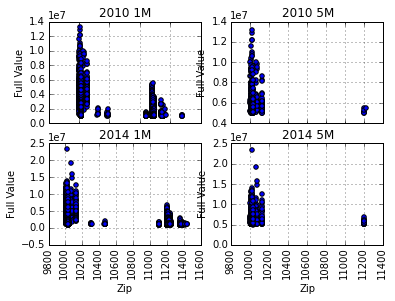

In [40]:
from matplotlib import pyplot as plt

# plot a figure containing 2x2 subplots (2010/14 x $1m/$5M)
fig, ((ax10_1M, ax10_5M), (ax14_1M, ax14_5M)) = plt.subplots(2, 2)

# 2010 subplots
df10res[df10res["Full Value"] >= 1e6].plot(
    ax=ax10_1M, y="Full Value", x="Zip", kind="scatter", title="2010 1M", rot=90)
df10res[df10res["Full Value"] >= 5e6].plot(
    ax=ax10_5M, y="Full Value", x="Zip", kind="scatter", title="2010 5M", rot=90)

# 2014 subplots
df14res[df14res["Full Value"] >= 1e6].plot(
    ax=ax14_1M, y="Full Value", x="Zip", kind="scatter", title="2014 1M", rot=90)
df14res[df14res["Full Value"] >= 5e6].plot(
    ax=ax14_5M, y="Full Value", x="Zip", kind="scatter", title="2014 5M", rot=90)

### Print sample tabular info.
# Houses > $1M; count how many in each zip code
print("\n\n2014: zip codes with most (count) houses > $1M: Park Slope area\n\n{}".format(
    df10res[df10res["Full Value"] >= 1e6].Zip.value_counts().head(5).to_string()))

# Houses > $5M; count how many in each zip code
print("\n\n2014: zip codes with most (count) houses > $5M: 10014/West Village area\n\n{}".format(
    df14res[df14res["Full Value"] >= 5e6].Zip.value_counts().head(5).to_string()))


## ===> New Query:

### Let's test the "Residential" column that we added. 

Which properties are listed in a particular zip code with/without the Residential filter applied?

The "all properties" listing is topped by the shipping port in Red Hook and other government properties with Tax Class = 4.<br>The "residential" listings are topped along residential Clinton, Kane and Tompkins streets, right next the Synagogue :)

### From results in the cell below: good enough.<br>This will allow us to do "residential" only type of queries.

In [41]:
# Choose 11231 (Red Hook/Gowanus,/Carroll Gardens area in Brooklyn).
df10_11231 = df10[df10.Zip == 11231].sort("Full Value", ascending=False)
df14_11231 = df14[df14.Zip == 11231].sort("Full Value", ascending=False)

cols_to_print = ["FullValueUX", "Owner", "Street Address", "Tax Class"]

print("2010 top 10 values (all properties) in zip=11231\n\n{}".format(
        df10_11231[:8][cols_to_print].to_string()))
print("\n\n2010 top 10 values (residential only) in zip=11231\n\n{}".format(
        df10_11231[df10_11231.Residential==True][:8][cols_to_print].to_string()))


# let's inform engine that it can garb.collect dataframes we won't use anymore
del df10_11231
del df14_11231

2010 top 10 values (all properties) in zip=11231

         FullValueUX                  Owner       Street Address Tax Class
264568  $100,200,000     DEPT RE-CITY OF NY   118 CONOVER STREET         4
265587   $42,600,000  ONE BEARD STREET, LLC      21 BEARD STREET         4
260478   $30,600,000     BOARD OF EDUCATION     610 HENRY STREET         4
263476   $21,500,000     BOARD OF EDUCATION   242 CARROLL STREET         4
265586   $20,685,000       640 COLUMBIA LLC  640 COLUMBIA STREET         4
265591   $13,460,000  GOWANUS INDUSTRIAL PA  685 COLUMBIA STREET         4
265588   $13,371,600  THOR 280 RICHARDS STR  280 RICHARDS STREET         4
265044   $13,100,000    183 LORRAINE STREET  183 LORRAINE STREET         4


2010 top 10 values (residential only) in zip=11231

       FullValueUX                Owner      Street Address Tax Class
257693  $3,610,000  FORMAN, ELIZABETH A     249 KANE STREET         1
258481  $3,600,000   SHARON E HUMPHREYS   36 TOMPKINS PLACE         1
258517  $3,

---

## ===> New Query:

### Top 10 values for residential properties NYC-wide?

2010's #2 rises to the top in 2014, almost doubling in value. Facing the East River:<br>
http://www.nytimes.com/2008/05/25/realestate/25deal1.html

In [42]:
print("2010 top 10 values (all properties) city-wide\n\n{}".format(
        df10res.sort("Full Value", ascending=False)[:5][cols_to_print]))

print("\n\n2014 top 10 values (all properties) city-wide\n\n{}".format(
        df14res.sort("Full Value", ascending=False)[:5][cols_to_print]))

2010 top 10 values (all properties) city-wide

       FullValueUX                 Owner         Street Address Tax Class
98611  $13,200,000           USDAN, ADAM     161 EAST 73 STREET         1
94452  $12,900,000  7 SUTTON SQUARE, LLC        7 SUTTON SQUARE         1
68546  $12,200,000         JANN S WENNER      27 WEST 74 STREET         1
31551  $12,200,000        SACKHEIM, CARL  689 WASHINGTON STREET         1
41583  $11,600,000      859 BROADWAY LLC           859 BROADWAY         1


2014 top 10 values (all properties) city-wide

        FullValueUX                 Owner      Street Address Tax Class
100511  $23,374,000  7 SUTTON SQUARE, LLC     7 SUTTON SQUARE         1
103958  $19,055,000  126 EAST 66TH STREET  126 EAST 66 STREET         1
102779  $15,822,000             CKLM, LLC     870 PARK AVENUE         1
102776  $14,848,000     A. ALEXANDER LARI   75 EAST 77 STREET         1
32610   $14,000,000      RESNICK, SCOTT N   293 WEST 4 STREET         1


#  !!!! work-in-progress below !!!!<br>!!!! work-in-progress below !!!!<br>!!!! work-in-progress below !!!!<br>

---
## ===> New Query:

In [43]:
#df14_ixzb.ix[11231, 464].plot(x="SquareFt", y="Full Value", kind="scatter")

In [44]:

#df10_res_1123x_grp_zb.apply(lambda df: df.sort_index(by="Full Value", ascending=False)[:2])[["FullValueUX", "Owner", "Street Address"]]



In [45]:
#hzb_grp["Full Value"].mean().plot(rot=90, style="x")

In [46]:
#df10_sqft1000s.groupby(["Zip", "SquareFt"]).median()[["Full Value"]].unstack("SquareFt").ix[11231].plot(rot=90)
#df10_sqft1000s.groupby(["Zip", "SquareFt"]).median()[["Full Value"]].unstack("SquareFt").ix[11231].index

In [47]:
#df10_sqft1000s.groupby(["Zip", "SquareFt"]).median()[["Full Value"]].unstack("SquareFt")[11230:11235]

In [48]:
%connect_info

{
  "stdin_port": 40774,
  "control_port": 50707,
  "signature_scheme": "hmac-sha256",
  "ip": "127.0.0.1",
  "key": "63e471ba-f63d-49cf-981c-b37e4f570bd8",
  "shell_port": 36330,
  "transport": "tcp",
  "hb_port": 51971,
  "iopub_port": 36519
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-ae806196-73f7-4720-bd18-ab956990f6f2.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [49]:
# when running all cells: the bucket stops here

assert False

AssertionError: 

# python client for enigma.io API - for now it just provides "export" support

In [ ]:
#!/usr/bin/env python

###########
##
##  Invoke like this:
##     ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2010
##     
##     (Note: The "export" request will keep on polling the file's URL location until
##            it becomes available, or until the max number of poll retries is reached.
##            Therefore, it's normal to see a sequence of polling msgs indicating that
##            the file was still not available.)
##     
##########


import os
import sys
import time
import argparse
import requests
from requests import RequestException

ARGPARSER = argparse.ArgumentParser()
ARGPARSER.add_argument("datapath")
ARGPARSER.add_argument("-o", "--outfname", dest="outfname", required=False)


class EnigmaClient:
    ENIG_RETCODE_SUCCESS = 0
    ENIG_RETCODE_TIMEOUT = 1
    ENIG_RETCODE_ERROR   = 2

    _QUERY_TEMPLATE = "https://api.enigma.io/v2/{op}/{key}/{datapath}/{params}"
    _EXPORTAPI_MAX_SECS_TIMEOUT = 120
    _EXPORTAPI_POLL_SECS_INTERVAL = 3
    _EXPORTAPI_CHUNK_SIZE = 1024 * 64

    def __init__(self, apikey):
        self.apikey = apikey


    # Tables are exported as Gzipped CSV files. 
    # 
    # Exports of large tables may take some time, so exports are processed
    # asynchronously.
    # 
    # When the export API is called, an export is queued and the API immediately
    # returns a URL pointing to the future location of the exported file. Users
    # should poll the URL until the file becomes available.
    # 
    # Note: this is a synchronous call. Caller waits (up to max_secs_timeout)
    #       until data is made available by Enigma backend, and then downloaded.
    #       Caller should check err_code if the export fails.
    # 
    # Returns one of: ENIG_RETCODE_SUCCESS, ENIG_RETCODE_TIMEOUT, ENIG_RETCODE_ERROR
    # 
    def export(self, datapath, parameters=None,
               max_secs_timeout=None, outfname=None):

        query_str = self._QUERY_TEMPLATE.format(op="export", key=self.apikey,
                                                datapath=datapath, params="")
        # make a query, which sends back the URL that we'll have to poll
        # until it eventually responds back with the gzipped csv file.
        resp = requests.get(query_str)
        resp_json = resp.json()
        export_url = resp_json["export_url"]

        if not outfname:
            # derive it from the URL
            outfname = export_url[export_url.strip("/").rfind("/")+1:]
            if "?" in outfname:
                outfname = outfname[:outfname.rfind("?")]

        return self._download_file(export_url, outfname)
        
    def _download_file(self, export_url, outfname):
        timeout_secs_remaining = self._EXPORTAPI_MAX_SECS_TIMEOUT
        poll_time_interval = self._EXPORTAPI_POLL_SECS_INTERVAL

        completed = False
        print("About to attempt downloading export URL: {}".format(export_url))
        while (not completed) and (timeout_secs_remaining > 0):
            print("\n***Retries timeout remaining: {} secs".format(timeout_secs_remaining))
            try:
                resp = requests.get(export_url, stream=True)
                if resp.ok is True:
                    print("\nFile ready - writing to local storage.")
                    with open(outfname, 'wb') as fout:
                        for chunk in resp.iter_content(
                                chunk_size=self._EXPORTAPI_CHUNK_SIZE): 
                            if chunk: # filter out keep-alive new chunks
                                fout.write(chunk)
                                fout.flush()
                    completed = True
                else:
                    print("File not ready yet - still polling."
                          "\n  Response status_code: {} - Reason: {}".format(
                        resp.status_code, resp.reason))
            except Exception as exc:
                print("exc: {}".format(exc))
            finally:
                if not completed:
                    time.sleep(poll_time_interval)
                    timeout_secs_remaining -= poll_time_interval

        if completed is True:
            return self.ENIG_RETCODE_SUCCESS
        elif timeout_secs_remaining < 0:
            return self.ENIG_RETCODE_TIMEOUT
        else:
            return self.ENIG_RETCODE_ERROR

        
def main(apikey, args):
    client = EnigmaClient(apikey)
    client.export(args.datapath, outfname=args.outfname)


if __name__ == "__main__":
    apikey = os.getenv("ENV_ENIGMA_APIKEY")
    if not apikey:
        print('Please set your env var "ENV_ENIGMA_APIKEY"')
        sys.exit(1)
    
    main(apikey, ARGPARSER.parse_args())
